In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from tslearn.clustering import TimeSeriesKMeans

/Users/alexbruefach/opt/anaconda3/envs/ds4aw/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
fp_p = '/Users/alexbruefach/Documents/GitHub/DSproject-covid-stress-impact/covid-policy-region/OxCGRT_latest.csv'
data_p = pd.read_csv(fp_p)

/Users/alexbruefach/opt/anaconda3/envs/ds4aw/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Policy Data Cleaning and Clustering

In [3]:
data_p = data_p[data_p['CountryCode']=='USA']
data_p = data_p.dropna(subset=['RegionName'])
data_p['Datetime'] = pd.to_datetime(data_p['Date'], format='%Y%m%d')
data_p = data_p[(data_p['Datetime']<pd.Timestamp(2021,6,1)) & (data_p['Datetime']>pd.Timestamp(2020,12,1))]

In [4]:
data_vacpol_usa = data_p[['RegionName', 'H7_Vaccination policy', 'Datetime']]

In [5]:
df_states = data_vacpol_usa.pivot(index='RegionName', columns='Datetime')['H7_Vaccination policy']
df_states = df_states.dropna(axis='columns')

In [6]:
states = data_p['RegionName'].unique()

In [7]:
from scipy.spatial import distance_matrix
df = df_states
X = pd.DataFrame(distance_matrix(df.values, df.values, p=1), 
                 index=df.index, columns=df.index)

In [38]:
n_clusters = 6
gmm = GaussianMixture(n_components = n_clusters, covariance_type = 'full')
gmm_labels =gmm.fit_predict(X)

In [114]:
dict_stategroups = dict(zip(states,gmm_labels))
state_groups = [list(df_states.index[gmm_labels == i]) for i in range(n_clusters)]

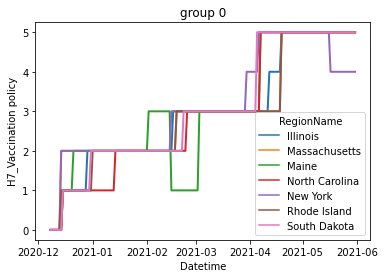

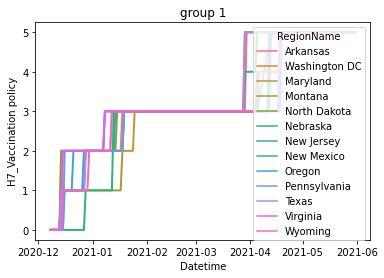

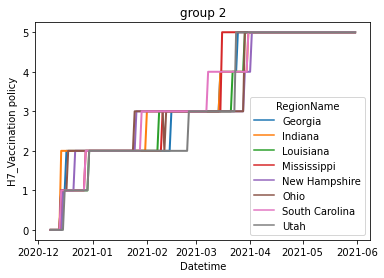

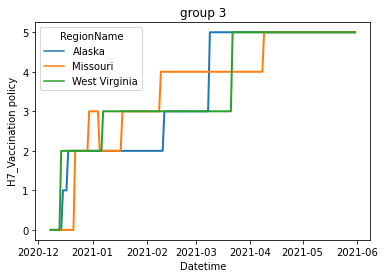

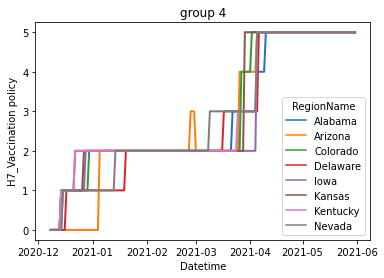

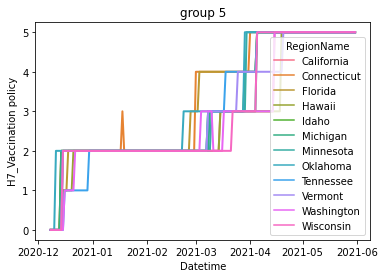

In [209]:
for i in range(n_clusters):
    data_onereg = data_p[data_p['RegionName'].isin(state_groups[i])]
    sns.lineplot(data=data_onereg, 
                 x='Datetime', 
                 y='H7_Vaccination policy', 
                 hue="RegionName",
                lw = 2)
    plt.title('group ' + str(i))
    plt.show()

In [99]:
## Save state dictionary
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [100]:
#save_obj(dict_stategroups, 'state_labels_10.17.21_classes=6')

## Stress dataset

In [190]:
fp_s = '/Users/alexbruefach/Documents/GitHub/DSproject-covid-stress-impact/covid19tracker_recoded.csv'
data_s = pd.read_csv(fp_s, encoding='latin-1')

In [191]:
data_s['month'] = pd.DatetimeIndex(data_s.endtime).month
data_s['year'] = pd.DatetimeIndex(data_s.endtime).year
data_s['year-month'] = pd.to_datetime(data_s[['year', 'month']].assign(DAY=1))

In [192]:
data_s.keys()

Index(['state', 'endtime', 'qweek', 'gender', 'age', 'household_size',
       'household_children', 'child_age_1', 'child_age_2', 'child_age_3',
       'child_age_4', 'child_age_5', 'child_education_1', 'child_education_2',
       'child_education_3', 'child_education_4', 'i10_health', 'i11_health',
       'r1_1', 'WCRV_4', 'employment_status', 'cantril_ladder', 'PHQ4_1',
       'PHQ4_2', 'PHQ4_3', 'PHQ4_4', 'CORE_B2_4', 'w4_1', 'w4_2', 'w4_3',
       'w4_4', 'w4_5', 'w4_6', 'w4_7', 'w4_8', 'w4_9', 'w4_10', 'w4_11',
       'w4_99', 'w4b', 'employment_status.cat', 'week', 'PHQ4_sum',
       'child_education_sum', 'month', 'year', 'year-month'],
      dtype='object')

In [193]:
# states_dict = {'Alabama': 1, 'Alaska': 0, 'Arizona': 3, 'Arkansas': 2, 
#                'California': 1, 'Colorado': 3, 'Connecticut': 0, 'Delaware': 3, 
#                'Florida': 0, 'Georgia': 0, 'Hawaii': 1, 'Idaho': 1, 'Illinois': 1, 
#                'Indiana': 0, 'Iowa': 3, 'Kansas': 3, 'Kentucky': 1, 'Louisiana': 0, 
#                'Maine': 1, 'Maryland': 2, 'Massachusetts': 1, 'Michigan': 1, 'Minnesota': 1, 
#                'Mississippi': 0, 'Missouri': 0, 'Montana': 2, 'Nebraska': 2, 'Nevada': 1, 
#                'New Hampshire': 2, 'New Jersey': 2, 'New Mexico': 2, 'New York': 1, 
#                'North Carolina': 1, 'North Dakota': 2, 'Ohio': 2, 'Oklahoma': 1, 'Oregon': 2, 
#                'Pennsylvania': 2, 'Rhode Island': 1, 'South Carolina': 0, 'South Dakota': 1, 
#                'Tennessee': 1, 'Texas': 2, 'Utah': 1, 'Vermont': 1, 'Virginia': 2, 'Washington': 1, 
#                'Washington DC': 2, 'West Virginia': 2, 'Wisconsin': 1, 'Wyoming': 2}

In [194]:
data_s = data_s.replace('District of Columbia','Washington DC')

In [195]:
data_state_list = data_s['state'].tolist()
state_labels = [dict_stategroups[i] for i in data_state_list]

In [196]:
data_s['state_labels'] = state_labels

## Exploratory Data Analysis

In [197]:
data_stress_additive = data_s[['state_labels', 'PHQ4_sum']]

In [203]:
colors = ['pink','cyan']

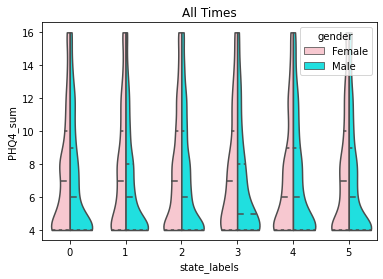

In [214]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum', 
               hue = 'gender',
               split = True,
               data = data_s.sort_values('gender'),
               inner='quartile',
              palette = colors,
              cut = 0)
plt.title('All Times')
plt.show()

In [199]:
## Group by dates
data_s_pre = data_s[(data_s['year-month']<pd.Timestamp(2020,11,30)) & (data_s['year-month']>pd.Timestamp(2020,8,31))]
data_s_dur = data_s[(data_s['year-month']<pd.Timestamp(2021,4,30)) & (data_s['year-month']>pd.Timestamp(2020,12,31))]
data_s_pos = data_s[(data_s['year-month']>pd.Timestamp(2021,4,30)) & (data_s['year-month']>pd.Timestamp(2020,7,31))]

In [200]:
data_s_pre['PHQ4_sum'].value_counts()

4.0     792
8.0     328
6.0     293
5.0     247
7.0     234
9.0     166
10.0    153
12.0    139
11.0    126
16.0    123
13.0     97
14.0     84
15.0     55
Name: PHQ4_sum, dtype: int64

In [201]:
data_s_pre.groupby('state_labels')['PHQ4_sum'].count()

state_labels
0    370
1    502
2    764
3    141
4    363
5    697
Name: PHQ4_sum, dtype: int64

In [202]:
data_s_dur.groupby('state_labels')['PHQ4_sum'].count()

state_labels
0    246
1    263
2    449
3     94
4    235
5    406
Name: PHQ4_sum, dtype: int64

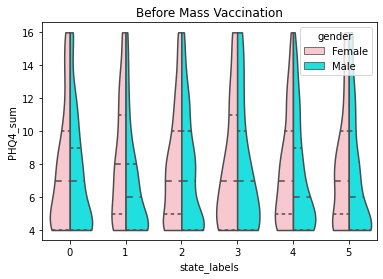

In [215]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum', 
               hue = 'gender',
               split = True,
               data = data_s_pre.sort_values('gender'),
               inner='quartile',
              palette = colors,
               cut = 0)
plt.title('Before Mass Vaccination')
plt.show()

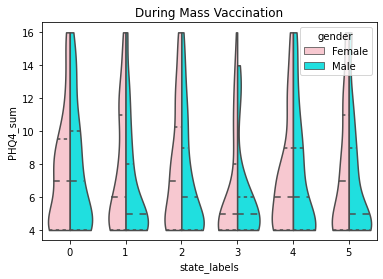

In [216]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum', 
               hue = 'gender',
               split = True,
               data = data_s_dur.sort_values('gender'), 
               inner='quartile',
              palette = colors,
               cut = 0)
plt.title('During Mass Vaccination')
plt.show()

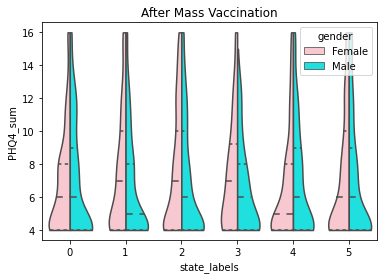

In [217]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum',
               hue = 'gender',
               split = True,
               data = data_s_pos.sort_values('gender'),
              inner='quartile',
              palette = colors,
              cut = 0)
plt.title('After Mass Vaccination')
plt.show()

## Covid confirmed cases

In [141]:
import pandas as pd

Dict_state = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "Washington DC": "DC",
}
    
Dict_region_ch = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}

Dict_regcode = {
    'O':'Other',
    'S':'South',
    'W':'West',
    'N':'North East',
    'M':'Mid West'
}

def us_state_to_code(key):
    """
    Key - string, state name
    """
    return Dict_state[key]

def states_to_regionChr(key):
    """
    maps from state code to region
    S: South, W:West, N:North East, M:Mid West O:other
    """
    return Dict_region_ch[key]

def regionchr_to_regioncode(key):
    """Key - string, region to code
    """
    return Dict_regcode[key]

def us_state_to_regioncode(key):
    return regionchr_to_regioncode(states_to_regionChr(us_state_to_code(key)))

In [146]:
regioncodes = []
for region in data_p['RegionName'].values:
    regioncode = us_state_to_regioncode(region)
    regioncodes.append(regioncode)

data_p['RegionCat'] = regioncodes

In [173]:
data_p

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,...,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay,Datetime,RegionCat
163128,United States,USA,Alaska,US_AK,STATE_TOTAL,20201202,3.0,0.0,2.0,0.0,...,68.57,68.57,58.85,58.85,61.90,61.90,37.5,37.5,2020-12-02,Other
163129,United States,USA,Alaska,US_AK,STATE_TOTAL,20201203,3.0,0.0,2.0,0.0,...,68.57,68.57,58.85,58.85,61.90,61.90,37.5,37.5,2020-12-03,Other
163130,United States,USA,Alaska,US_AK,STATE_TOTAL,20201204,3.0,0.0,2.0,0.0,...,68.57,68.57,58.85,58.85,61.90,61.90,37.5,37.5,2020-12-04,Other
163131,United States,USA,Alaska,US_AK,STATE_TOTAL,20201205,3.0,0.0,2.0,0.0,...,68.57,68.57,58.85,58.85,61.90,61.90,37.5,37.5,2020-12-05,Other
163132,United States,USA,Alaska,US_AK,STATE_TOTAL,20201206,3.0,0.0,2.0,0.0,...,68.57,68.57,58.85,58.85,61.90,61.90,37.5,37.5,2020-12-06,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195604,United States,USA,Wyoming,US_WY,STATE_TOTAL,20210527,1.0,1.0,0.0,NaN,...,60.71,60.71,49.48,49.48,51.19,51.19,37.5,37.5,2021-05-27,West
195605,United States,USA,Wyoming,US_WY,STATE_TOTAL,20210528,1.0,1.0,0.0,NaN,...,60.71,60.71,49.48,49.48,51.19,51.19,37.5,37.5,2021-05-28,West
195606,United States,USA,Wyoming,US_WY,STATE_TOTAL,20210529,1.0,1.0,0.0,NaN,...,60.71,60.71,49.48,49.48,51.19,51.19,37.5,37.5,2021-05-29,West
195607,United States,USA,Wyoming,US_WY,STATE_TOTAL,20210530,1.0,1.0,0.0,NaN,...,60.71,60.71,49.48,49.48,51.19,51.19,37.5,37.5,2021-05-30,West


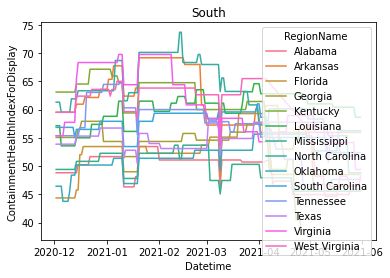

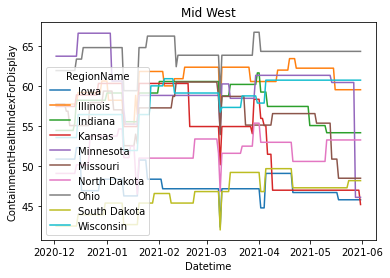

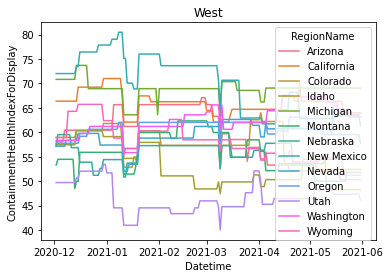

In [148]:
features = ['GovernmentResponseIndexForDisplay','ContainmentHealthIndexForDisplay',
            'StringencyIndexForDisplay', 'EconomicSupportIndexForDisplay']
feature = features[1]

data_i = data_p
data_onereg = data_i[data_i['RegionCat']=='South']
sns.lineplot(data=data_onereg, x='Datetime', y=feature, hue="RegionName")
plt.title('South')
plt.show()

data_onereg = data_i[data_i['RegionCat']=='Mid West']
sns.lineplot(data=data_onereg, x='Datetime', y=feature, hue="RegionName")
plt.title('Mid West')
plt.show()

data_onereg = data_i[data_i['RegionCat']=='West']
sns.lineplot(data=data_onereg, x='Datetime', y=feature, hue="RegionName")
plt.title('West')
plt.show()

In [177]:
n_clusters = 6
gmm = GaussianMixture(n_components = n_clusters, covariance_type = 'full')
policy_labels = []

for i in range(len(features)):
    data = pd.DataFrame(data_p[['RegionName', features[i]]].dropna())
    policy_labels.append(gmm.fit_predict(data))
    dict_stategroups.append[dict(zip(states,policy_labels[i]))]

ValueError: could not convert string to float: 'Alaska'

In [ ]:

state_groups = [list(df_states.index[gmm_labels == i]) for i in range(n_clusters)]

In [151]:
data_usa_time = data_p[(data_p['Datetime']<pd.Timestamp(2021,6,1)) & (data_p['Datetime']>pd.Timestamp(2020,12,1))]

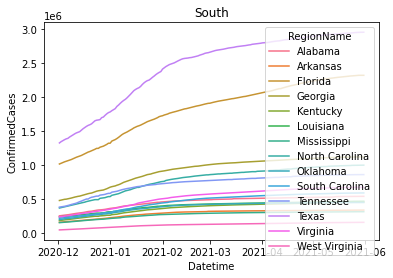

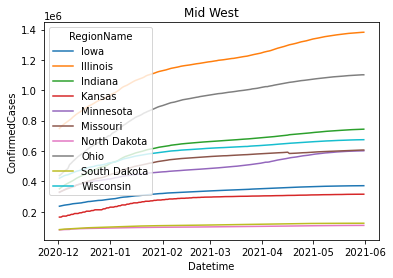

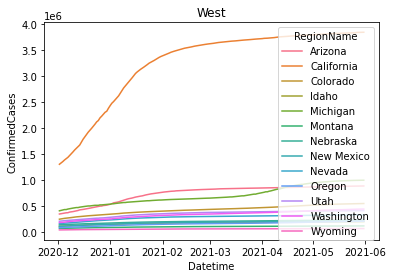

In [152]:
feature = 'ConfirmedCases'
data_onereg = data_usa_time[data_usa_time['RegionCat']=='South']
sns.lineplot(data=data_onereg, x='Datetime', y=feature, hue="RegionName")
plt.title('South')
plt.show()

data_onereg = data_usa_time[data_usa_time['RegionCat']=='Mid West']
sns.lineplot(data=data_onereg, x='Datetime', y=feature, hue="RegionName")
plt.title('Mid West')
plt.show()

data_onereg = data_usa_time[data_usa_time['RegionCat']=='West']
sns.lineplot(data=data_onereg, x='Datetime', y=feature, hue="RegionName")
plt.title('West')
plt.show()

## four aggregated policies

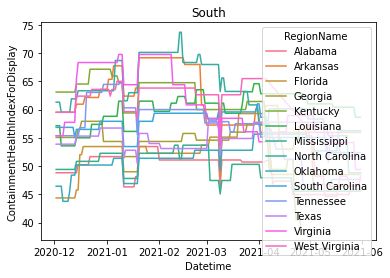

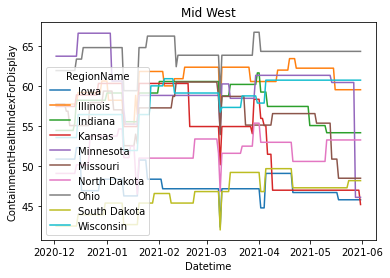

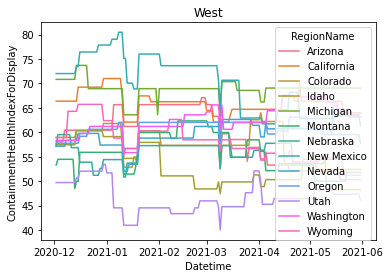

In [153]:
features = ['GovernmentResponseIndexForDisplay','ContainmentHealthIndexForDisplay',
            'StringencyIndexForDisplay', 'EconomicSupportIndexForDisplay']
feature = features[1]

data_i = data_usa_time
data_onereg = data_i[data_i['RegionCat']=='South']
sns.lineplot(data=data_onereg, x='Datetime', y=feature, hue="RegionName")
plt.title('South')
plt.show()

data_onereg = data_i[data_i['RegionCat']=='Mid West']
sns.lineplot(data=data_onereg, x='Datetime', y=feature, hue="RegionName")
plt.title('Mid West')
plt.show()

data_onereg = data_i[data_i['RegionCat']=='West']
sns.lineplot(data=data_onereg, x='Datetime', y=feature, hue="RegionName")
plt.title('West')
plt.show()

## Face covering (part of government response and contarinment&health index)

<AxesSubplot:xlabel='Datetime', ylabel='ConfirmedCases'>

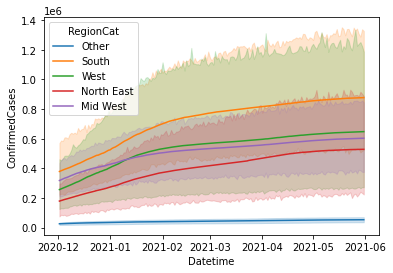

In [155]:

sns.lineplot(data=data_p, x='Datetime', y='ConfirmedCases', hue="RegionCat")

## School closing

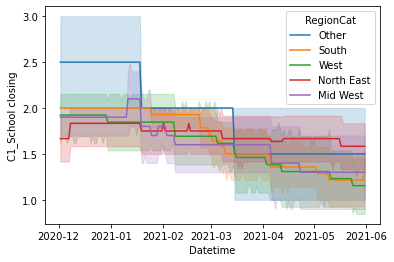

In [156]:
sns.lineplot(data=data_p, x='Datetime', y='C1_School closing', hue="RegionCat")
plt.show()

<AxesSubplot:>

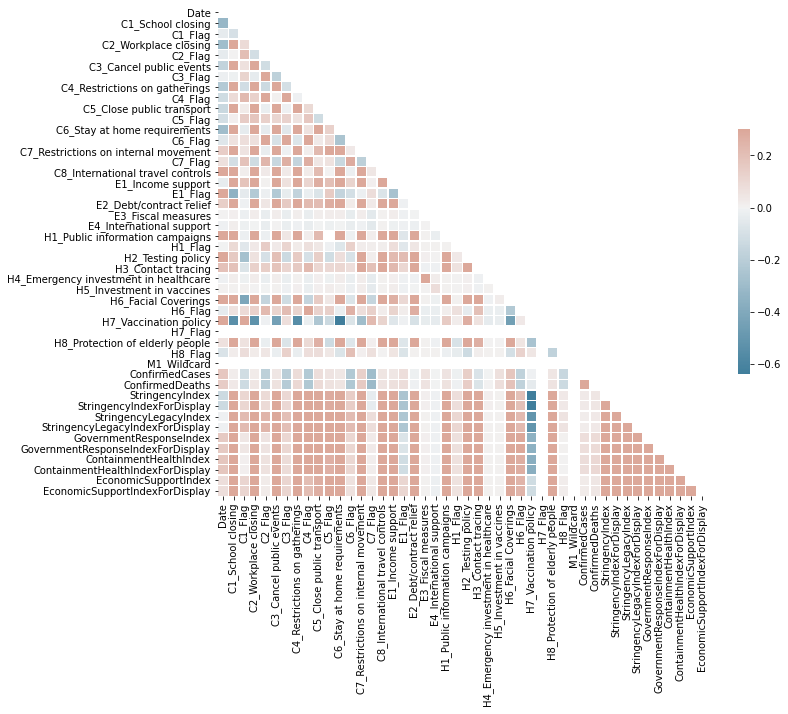

In [51]:
import numpy as np
import matplotlib.pyplot as plt

d = data_usa
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [124]:
def us_state_to_code():
    
    Dict = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "Washington DC": "DC",
}
    
    return Dict

def states_to_regionChr():
    """
    maps from state code to region
    S: South, W:West, N:North East, M:Mid West O:other
    """
    Dict = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}
    return Dict

def regionchr_to_regioncode():
    return {'O':'Other', 'S':'South', 'W':'West', 'N':'North East', 'M':'Mid West'}